# Lesson 1.6: Image Noise and Filtering
## Biomedical Image Processing - Basic Concepts

### Topics:
- Types of noise in medical images
- Noise generation and modeling
- Spatial filtering techniques
- Noise reduction methods
- Applications in medical imaging

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. What is Image Noise?

**Noise** is unwanted random variation in pixel values that degrades image quality.

In medical imaging, noise can come from:
- **Sensor noise** (electronic interference)
- **Quantum noise** (low photon count in X-ray/CT)
- **Thermal noise** (heat in sensors)
- **Transmission errors** (data corruption)

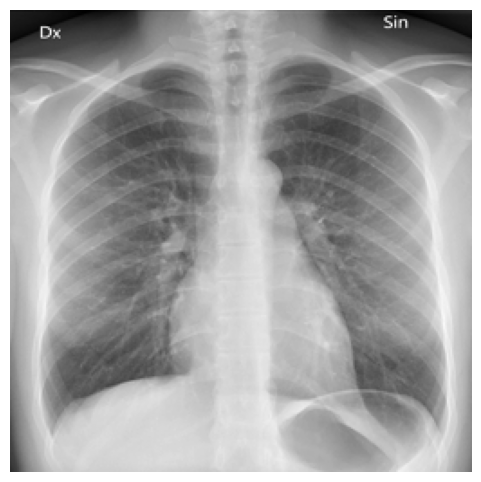

Image shape: (256, 256)
Pixel range: 0 - 216


In [17]:
# Load our medical image
img_path = os.path.join(current_dir, 'chest_xray.jpg')

original = np.array(Image.open(img_path).convert('L').resize((256, 256)))
plt.figure(figsize=(6, 6))
plt.imshow(original, cmap='gray')
plt.axis('off')
plt.show()

print(f"Image shape: {original.shape}")
print(f"Pixel range: {original.min()} - {original.max()}")

## 2. Types of Noise

### 2.1 Gaussian Noise
- Most common noise type
- Follows normal distribution
- Common in: Electronic sensors, thermal noise

### 2.2 Salt and Pepper Noise (Impulse Noise)
- Random black and white pixels
- Common in: Data transmission errors, dead pixels

### 2.3 Poisson Noise (Shot Noise)
- Signal-dependent noise
- Common in: X-ray, CT (photon counting)

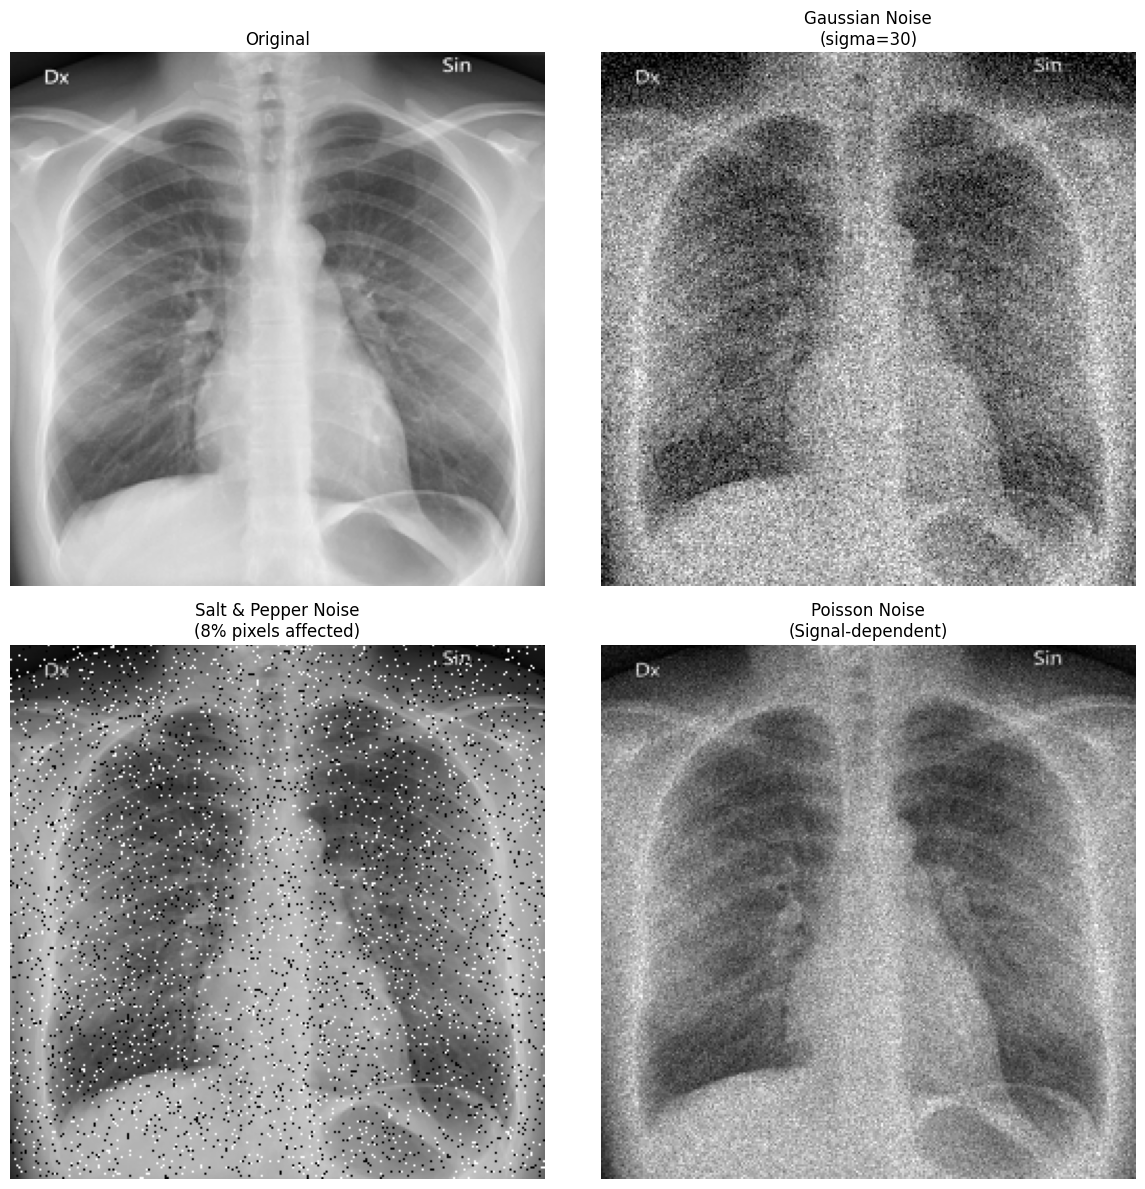

In [3]:
def add_gaussian_noise(img, mean=0, sigma=25):
    """Add Gaussian (normal) noise to image."""
    noise = np.random.normal(mean, sigma, img.shape)
    noisy = img.astype(np.float32) + noise
    return np.clip(noisy, 0, 255).astype(np.uint8)

def add_salt_pepper_noise(img, amount=0.05):
    """Add salt and pepper (impulse) noise."""
    noisy = img.copy()
    
    # Salt (white pixels)
    num_salt = int(amount * img.size / 2)
    salt_coords = (np.random.randint(0, img.shape[0], num_salt),
                   np.random.randint(0, img.shape[1], num_salt))
    noisy[salt_coords] = 255
    
    # Pepper (black pixels)
    num_pepper = int(amount * img.size / 2)
    pepper_coords = (np.random.randint(0, img.shape[0], num_pepper),
                     np.random.randint(0, img.shape[1], num_pepper))
    noisy[pepper_coords] = 0
    
    return noisy

def add_poisson_noise(img, scale=1.0):
    """Add Poisson (shot) noise - signal dependent."""
    # Poisson noise is signal-dependent
    noisy = np.random.poisson(img.astype(np.float32) * scale) / scale
    return np.clip(noisy, 0, 255).astype(np.uint8)

# Generate noisy images
np.random.seed(42)
gaussian_noisy = add_gaussian_noise(original, sigma=30)
sp_noisy = add_salt_pepper_noise(original, amount=0.08)
poisson_noisy = add_poisson_noise(original, scale=0.5)

# Display
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

axes[0, 0].imshow(original, cmap='gray')
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

axes[0, 1].imshow(gaussian_noisy, cmap='gray')
axes[0, 1].set_title('Gaussian Noise\n(sigma=30)')
axes[0, 1].axis('off')

axes[1, 0].imshow(sp_noisy, cmap='gray')
axes[1, 0].set_title('Salt & Pepper Noise\n(8% pixels affected)')
axes[1, 0].axis('off')

axes[1, 1].imshow(poisson_noisy, cmap='gray')
axes[1, 1].set_title('Poisson Noise\n(Signal-dependent)')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

## 3. Understanding Noise Characteristics

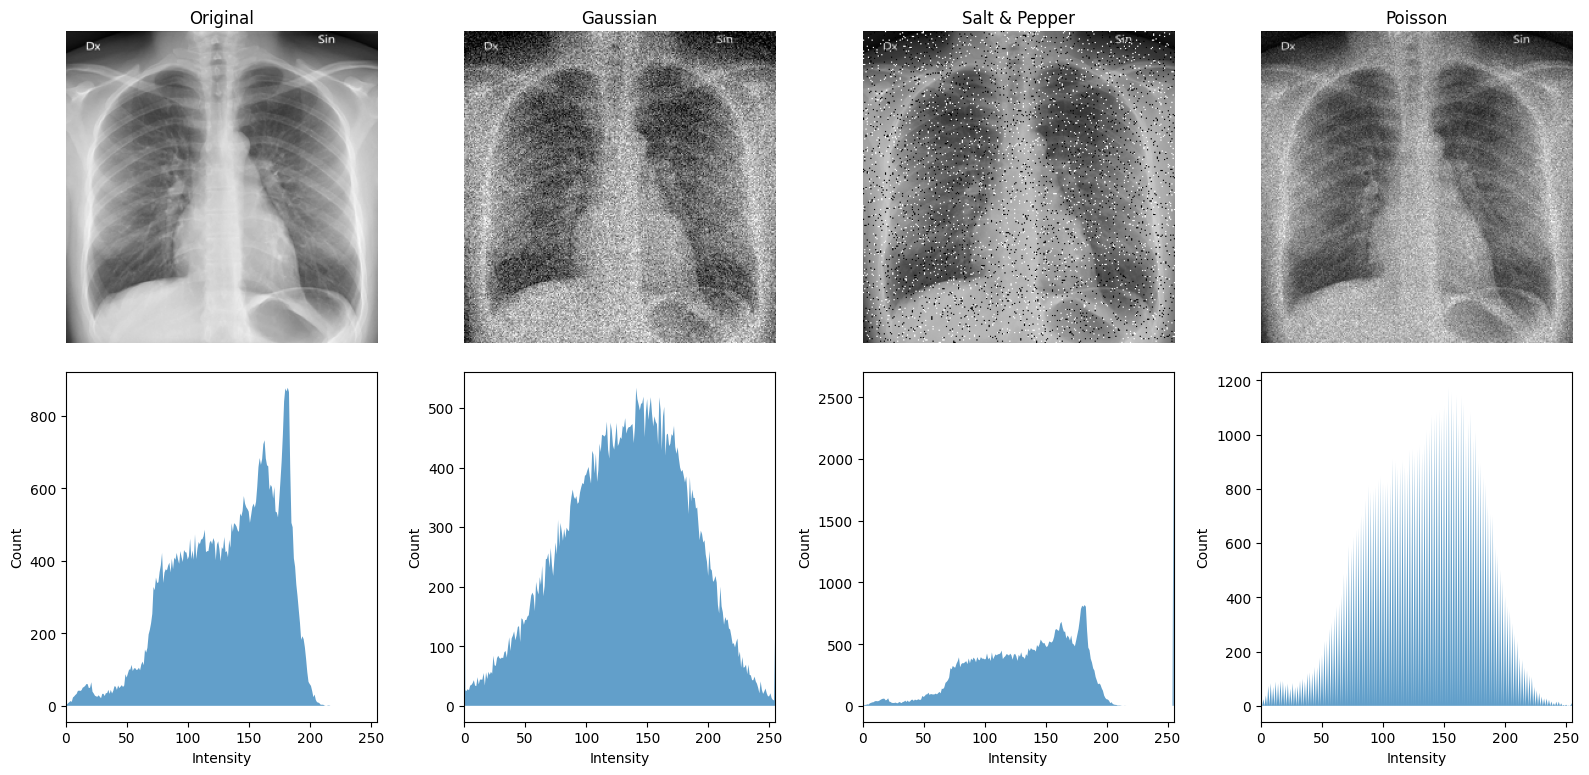


Noise Statistics:
Type                 Mean         Std Dev      MSE         
------------------------------------------------------------
Original             132.28       41.11        0.00        
Gaussian             131.94       50.70        891.31      
Salt & Pepper        131.77       53.03        1382.60     
Poisson              132.31       44.33        268.01      


In [4]:
# Compare histograms of noise types
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

images = [
    (original, 'Original'),
    (gaussian_noisy, 'Gaussian'),
    (sp_noisy, 'Salt & Pepper'),
    (poisson_noisy, 'Poisson')
]

for i, (img, title) in enumerate(images):
    # Image
    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].set_title(title)
    axes[0, i].axis('off')
    
    # Histogram
    hist, _ = np.histogram(img.flatten(), bins=256, range=(0, 256))
    axes[1, i].fill_between(range(256), hist, alpha=0.7)
    axes[1, i].set_xlim(0, 255)
    axes[1, i].set_xlabel('Intensity')
    axes[1, i].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Calculate statistics
print("\nNoise Statistics:")
print("=" * 60)
print(f"{'Type':<20} {'Mean':<12} {'Std Dev':<12} {'MSE':<12}")
print("-" * 60)

for img, title in images:
    mse = np.mean((img.astype(float) - original.astype(float))**2) if title != 'Original' else 0
    print(f"{title:<20} {np.mean(img):<12.2f} {np.std(img):<12.2f} {mse:<12.2f}")

## 4. Spatial Filtering Basics

**Spatial filters** work by replacing each pixel with a function of its neighbors.

Common approaches:
- **Linear filters**: Weighted average of neighbors (convolution)
- **Non-linear filters**: Median, min, max operations

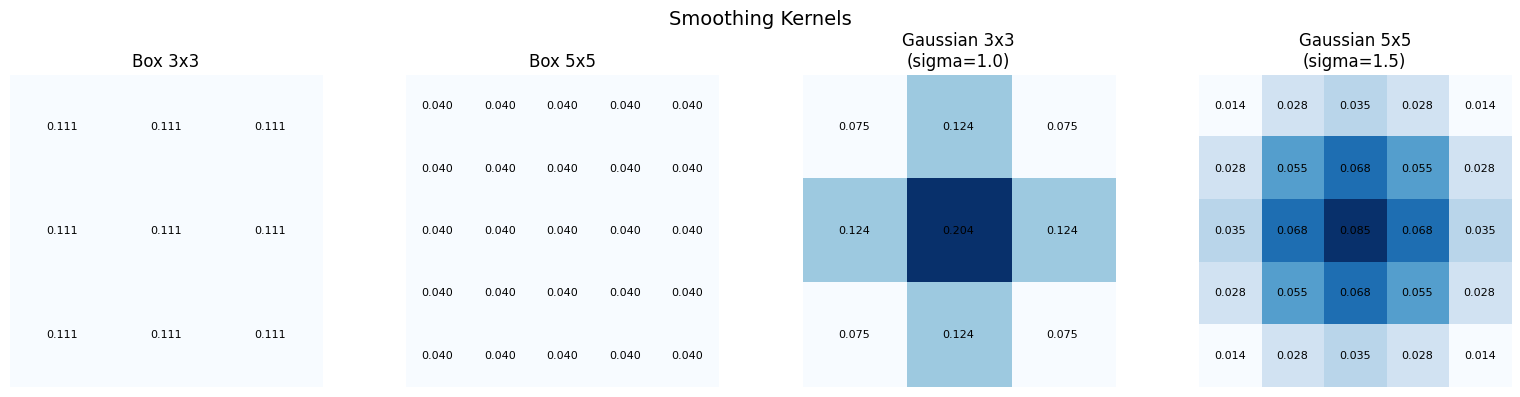

In [5]:
def convolve2d(img, kernel):
    """Apply 2D convolution with a kernel."""
    h, w = img.shape
    kh, kw = kernel.shape
    pad_h, pad_w = kh // 2, kw // 2
    
    # Pad image with edge values
    padded = np.pad(img.astype(np.float32), ((pad_h, pad_h), (pad_w, pad_w)), mode='edge')
    output = np.zeros((h, w), dtype=np.float32)
    
    for i in range(h):
        for j in range(w):
            region = padded[i:i+kh, j:j+kw]
            output[i, j] = np.sum(region * kernel)
    
    return output

# Common smoothing kernels
# Box filter (average)
box_3x3 = np.ones((3, 3)) / 9
box_5x5 = np.ones((5, 5)) / 25

# Gaussian kernel
def gaussian_kernel(size, sigma):
    """Create a Gaussian kernel."""
    x = np.arange(size) - size // 2
    kernel_1d = np.exp(-x**2 / (2 * sigma**2))
    kernel_2d = np.outer(kernel_1d, kernel_1d)
    return kernel_2d / kernel_2d.sum()

gaussian_3x3 = gaussian_kernel(3, 1.0)
gaussian_5x5 = gaussian_kernel(5, 1.5)

# Visualize kernels
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

kernels = [
    (box_3x3, 'Box 3x3'),
    (box_5x5, 'Box 5x5'),
    (gaussian_3x3, 'Gaussian 3x3\n(sigma=1.0)'),
    (gaussian_5x5, 'Gaussian 5x5\n(sigma=1.5)')
]

for ax, (kernel, title) in zip(axes, kernels):
    im = ax.imshow(kernel, cmap='Blues')
    ax.set_title(title)
    for i in range(kernel.shape[0]):
        for j in range(kernel.shape[1]):
            ax.text(j, i, f'{kernel[i,j]:.3f}', ha='center', va='center', fontsize=8)
    ax.axis('off')

plt.suptitle('Smoothing Kernels', fontsize=14)
plt.tight_layout()
plt.show()

## 5. Linear Filters: Box and Gaussian

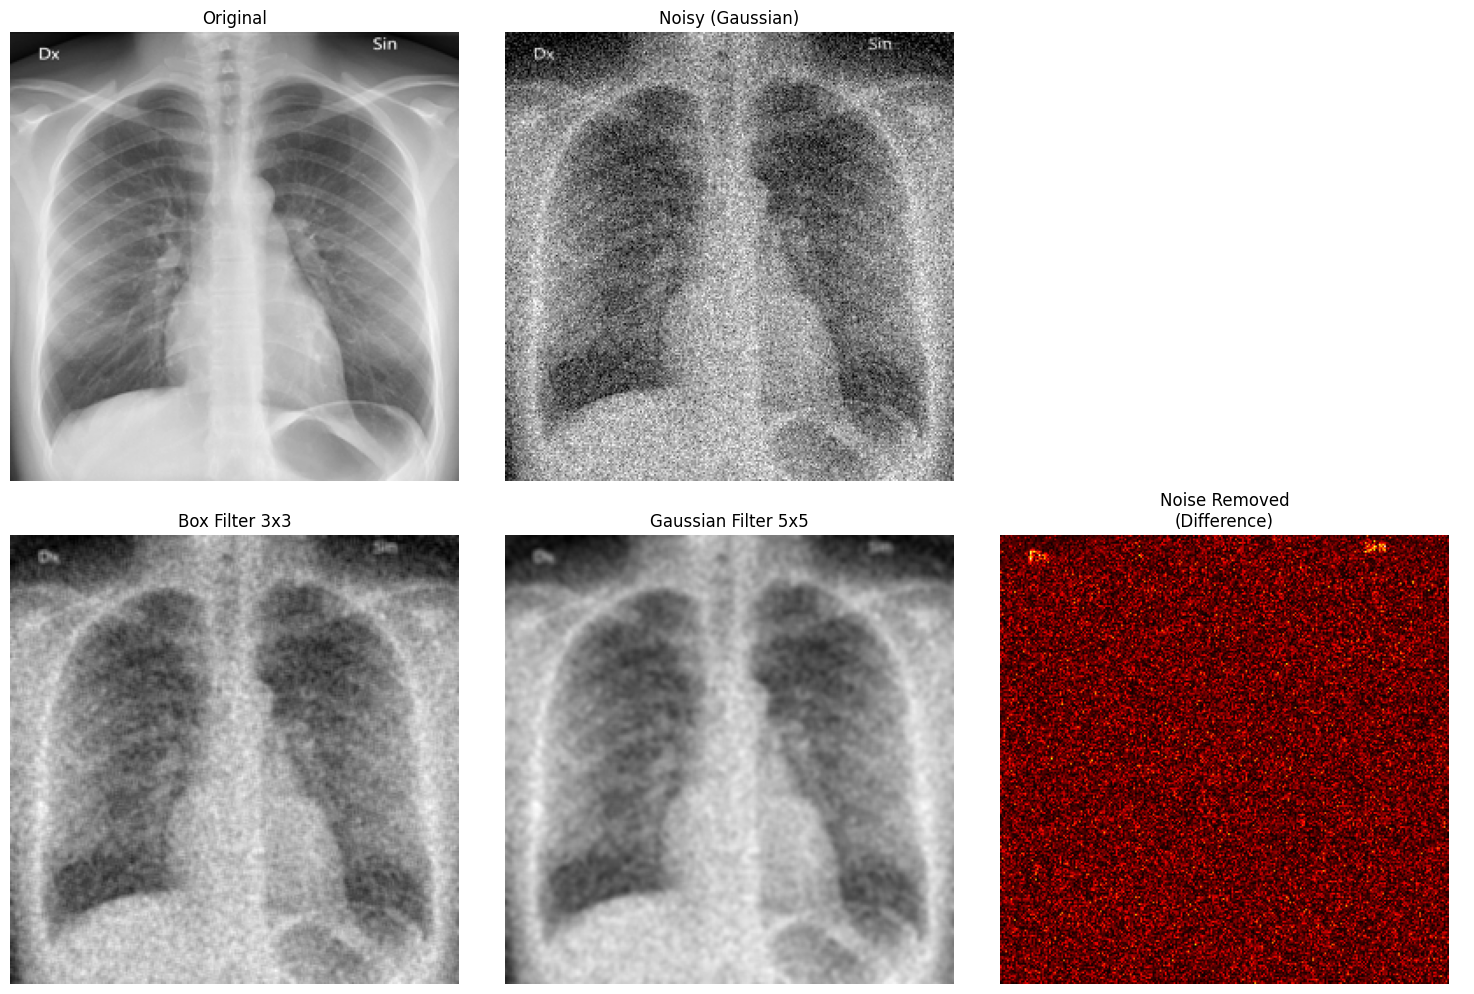


Quality Metrics (PSNR - higher is better):
Noisy image: 18.63 dB
Box filtered: 27.50 dB
Gaussian filtered: 29.91 dB


In [6]:
# Apply filters to Gaussian noisy image
box_filtered = convolve2d(gaussian_noisy, box_3x3)
gaussian_filtered = convolve2d(gaussian_noisy, gaussian_5x5)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(original, cmap='gray')
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

axes[0, 1].imshow(gaussian_noisy, cmap='gray')
axes[0, 1].set_title('Noisy (Gaussian)')
axes[0, 1].axis('off')

axes[0, 2].axis('off')  # Empty

axes[1, 0].imshow(box_filtered, cmap='gray')
axes[1, 0].set_title('Box Filter 3x3')
axes[1, 0].axis('off')

axes[1, 1].imshow(gaussian_filtered, cmap='gray')
axes[1, 1].set_title('Gaussian Filter 5x5')
axes[1, 1].axis('off')

# Show difference (noise removed)
diff = np.abs(gaussian_noisy.astype(float) - gaussian_filtered)
axes[1, 2].imshow(diff, cmap='hot')
axes[1, 2].set_title('Noise Removed\n(Difference)')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Calculate quality metrics
def psnr(original, processed):
    """Peak Signal-to-Noise Ratio."""
    mse = np.mean((original.astype(float) - processed.astype(float))**2)
    if mse == 0:
        return float('inf')
    return 10 * np.log10(255**2 / mse)

print("\nQuality Metrics (PSNR - higher is better):")
print(f"Noisy image: {psnr(original, gaussian_noisy):.2f} dB")
print(f"Box filtered: {psnr(original, box_filtered):.2f} dB")
print(f"Gaussian filtered: {psnr(original, gaussian_filtered):.2f} dB")

## 6. Non-Linear Filters: Median Filter

The **median filter** replaces each pixel with the median of its neighbors.

**Best for**: Salt and Pepper noise!
**Advantage**: Preserves edges better than linear filters.

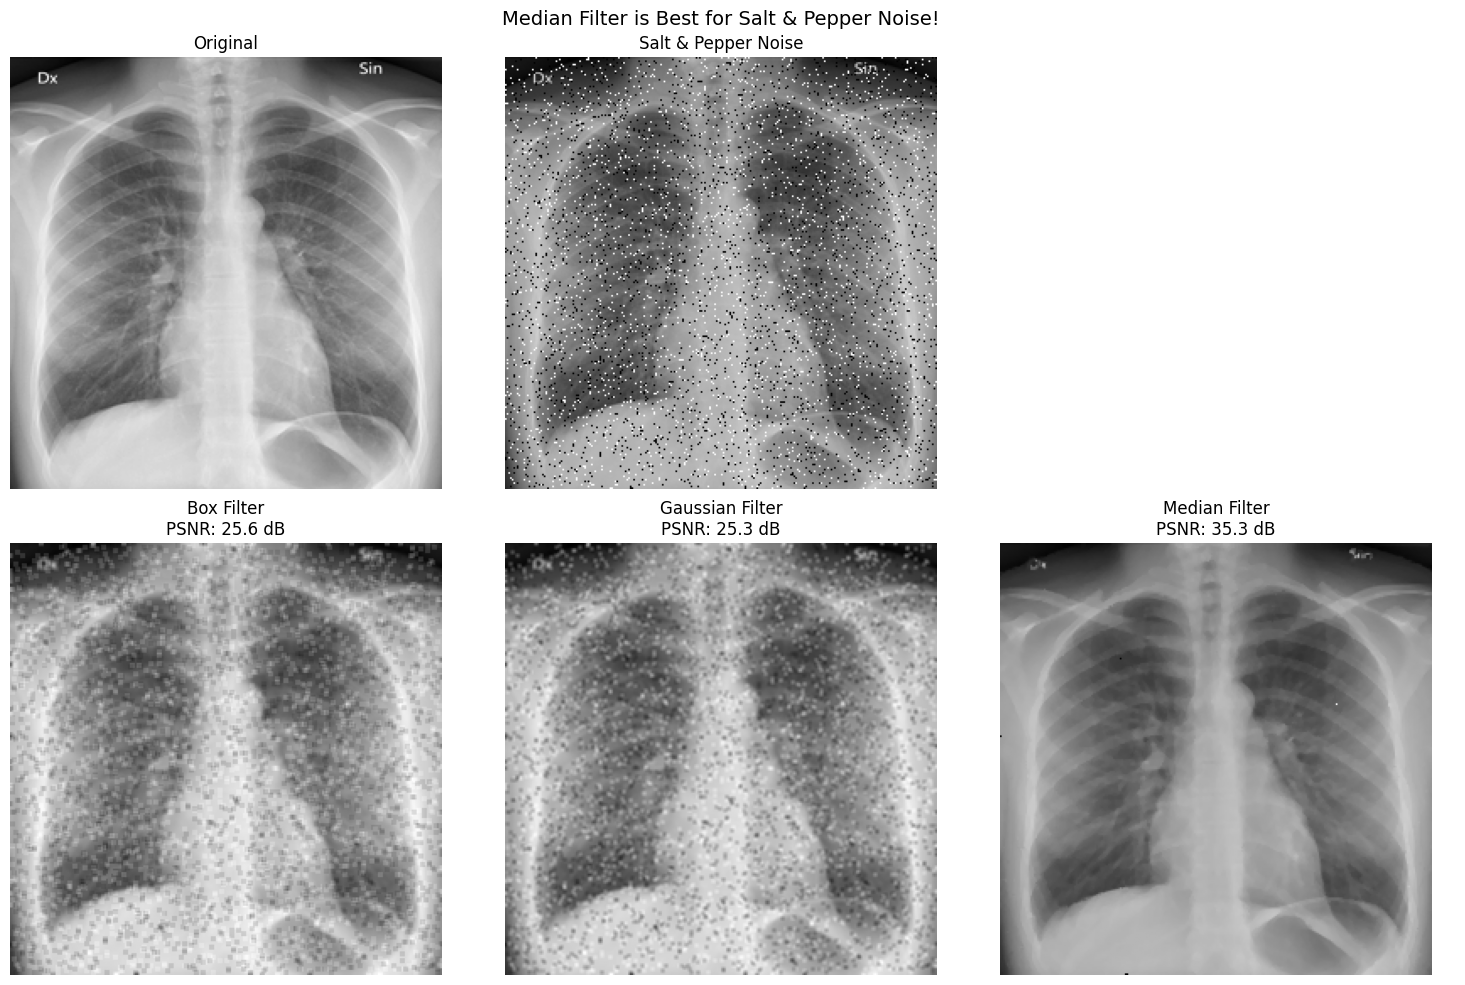


Notice: Median filter almost completely removes salt & pepper noise!
Linear filters (box, gaussian) just blur the noise.


In [7]:
def median_filter(img, size=3):
    """Apply median filter."""
    h, w = img.shape
    pad = size // 2
    
    padded = np.pad(img, pad, mode='edge')
    output = np.zeros((h, w), dtype=np.uint8)
    
    for i in range(h):
        for j in range(w):
            region = padded[i:i+size, j:j+size]
            output[i, j] = np.median(region)
    
    return output

# Compare filters on Salt & Pepper noise
sp_box = convolve2d(sp_noisy, box_3x3)
sp_gaussian = convolve2d(sp_noisy, gaussian_3x3)
sp_median = median_filter(sp_noisy, size=3)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(original, cmap='gray')
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

axes[0, 1].imshow(sp_noisy, cmap='gray')
axes[0, 1].set_title('Salt & Pepper Noise')
axes[0, 1].axis('off')

axes[0, 2].axis('off')

axes[1, 0].imshow(sp_box, cmap='gray')
axes[1, 0].set_title(f'Box Filter\nPSNR: {psnr(original, sp_box):.1f} dB')
axes[1, 0].axis('off')

axes[1, 1].imshow(sp_gaussian, cmap='gray')
axes[1, 1].set_title(f'Gaussian Filter\nPSNR: {psnr(original, sp_gaussian):.1f} dB')
axes[1, 1].axis('off')

axes[1, 2].imshow(sp_median, cmap='gray')
axes[1, 2].set_title(f'Median Filter\nPSNR: {psnr(original, sp_median):.1f} dB')
axes[1, 2].axis('off')

plt.suptitle('Median Filter is Best for Salt & Pepper Noise!', fontsize=14)
plt.tight_layout()
plt.show()

print("\nNotice: Median filter almost completely removes salt & pepper noise!")
print("Linear filters (box, gaussian) just blur the noise.")

## 7. Why Median Filter Works

Let's see step by step how median filter removes impulse noise.

3x3 Window with Salt Noise (255) at center:
[[100 102  98]
 [ 99 255 101]
 [101 100  99]]

All values: [100, 102, 98, 99, 255, 101, 101, 100, 99]
Sorted:     [98, 99, 99, 100, 100, 101, 101, 102, 255]
Median:     100

The noisy pixel (255) is replaced with the median (100)!
Notice: 255 is an outlier that doesn't affect the median.


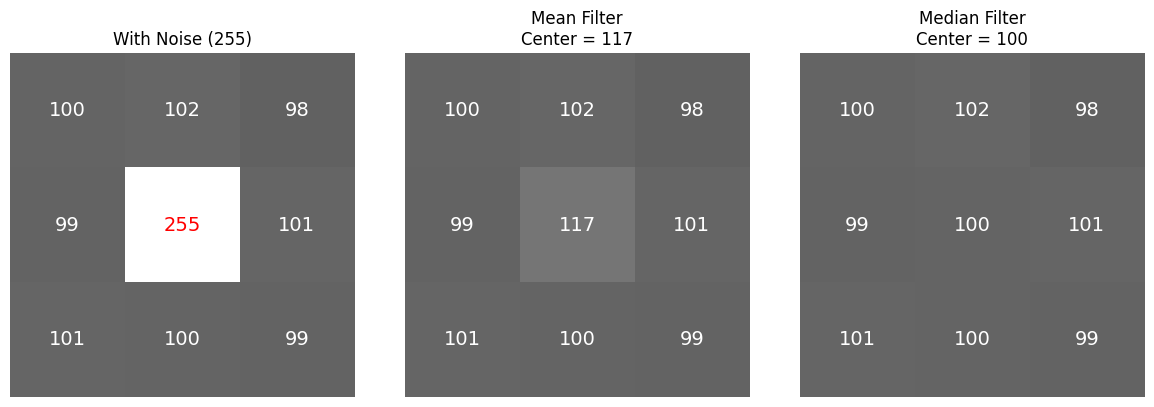

In [8]:
# Simple demonstration
demo = np.array([
    [100, 102, 98],
    [99, 255, 101],  # 255 is salt noise
    [101, 100, 99]
], dtype=np.uint8)

demo_noisy = demo.copy()
center_neighbors = demo.flatten()
sorted_neighbors = np.sort(center_neighbors)
median_value = sorted_neighbors[len(sorted_neighbors) // 2]

print("3x3 Window with Salt Noise (255) at center:")
print(demo)
print(f"\nAll values: {center_neighbors.tolist()}")
print(f"Sorted:     {sorted_neighbors.tolist()}")
print(f"Median:     {median_value}")
print("\nThe noisy pixel (255) is replaced with the median (100)!")
print("Notice: 255 is an outlier that doesn't affect the median.")

# Visual comparison
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(demo, cmap='gray', vmin=0, vmax=255)
axes[0].set_title('With Noise (255)')
for i in range(3):
    for j in range(3):
        color = 'red' if demo[i,j] == 255 else 'white'
        axes[0].text(j, i, str(demo[i,j]), ha='center', va='center', color=color, fontsize=14)
axes[0].axis('off')

demo_mean = demo.copy()
demo_mean[1, 1] = np.mean(demo)  # Mean filter result
axes[1].imshow(demo_mean, cmap='gray', vmin=0, vmax=255)
axes[1].set_title(f'Mean Filter\nCenter = {np.mean(demo):.0f}')
for i in range(3):
    for j in range(3):
        axes[1].text(j, i, f'{demo_mean[i,j]:.0f}', ha='center', va='center', color='white', fontsize=14)
axes[1].axis('off')

demo_median = demo.copy()
demo_median[1, 1] = median_value
axes[2].imshow(demo_median, cmap='gray', vmin=0, vmax=255)
axes[2].set_title(f'Median Filter\nCenter = {median_value}')
for i in range(3):
    for j in range(3):
        axes[2].text(j, i, str(demo_median[i,j]), ha='center', va='center', color='white', fontsize=14)
axes[2].axis('off')

plt.tight_layout()
plt.show()

## 8. Filter Size Trade-off

Larger filters = More smoothing, but more blur

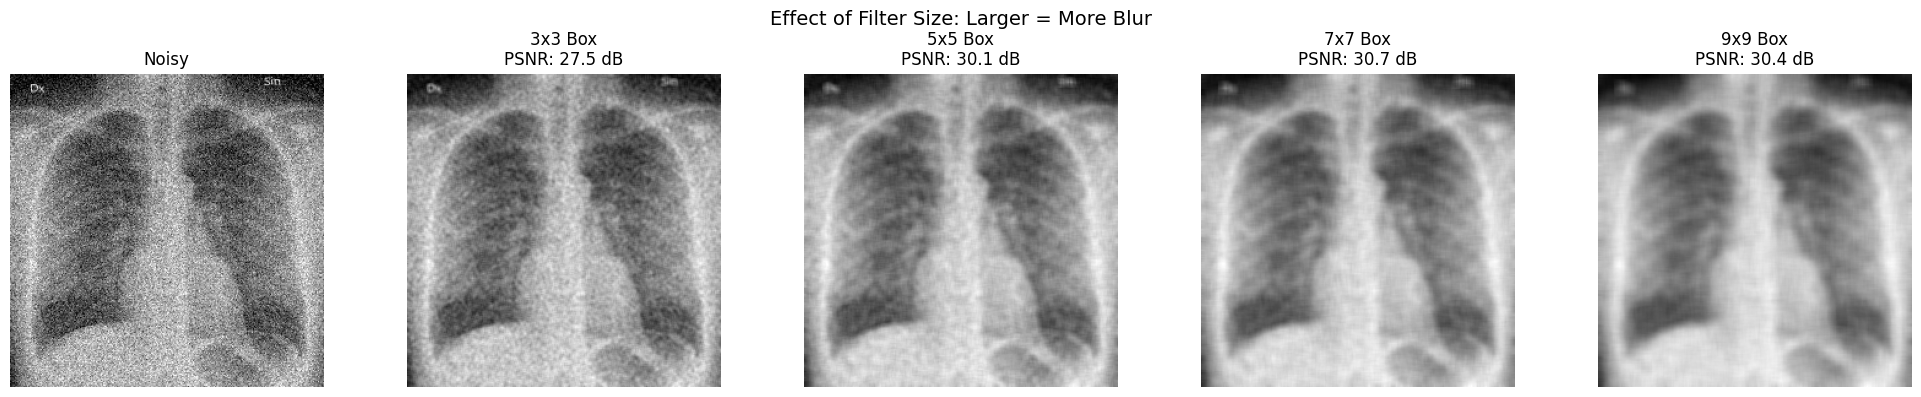

Observation: Larger kernels remove more noise but also blur edges.
PSNR initially improves, then decreases as blur becomes too much.


In [10]:
# Compare different kernel sizes
sizes = [3, 5, 7, 9]
filtered_images = []

for size in sizes:
    kernel = np.ones((size, size)) / (size * size)
    filtered = convolve2d(gaussian_noisy, kernel)
    filtered_images.append(filtered)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

axes[0].imshow(gaussian_noisy, cmap='gray')
axes[0].set_title('Noisy')
axes[0].axis('off')

for i, (size, img) in enumerate(zip(sizes, filtered_images)):
    axes[i+1].imshow(img, cmap='gray')
    axes[i+1].set_title(f'{size}x{size} Box\nPSNR: {psnr(original, img):.1f} dB')
    axes[i+1].axis('off')

plt.suptitle('Effect of Filter Size: Larger = More Blur', fontsize=14)
plt.tight_layout()
plt.show()

print("Observation: Larger kernels remove more noise but also blur edges.")
print("PSNR initially improves, then decreases as blur becomes too much.")

## 10. Medical Imaging Application: X-ray Denoising

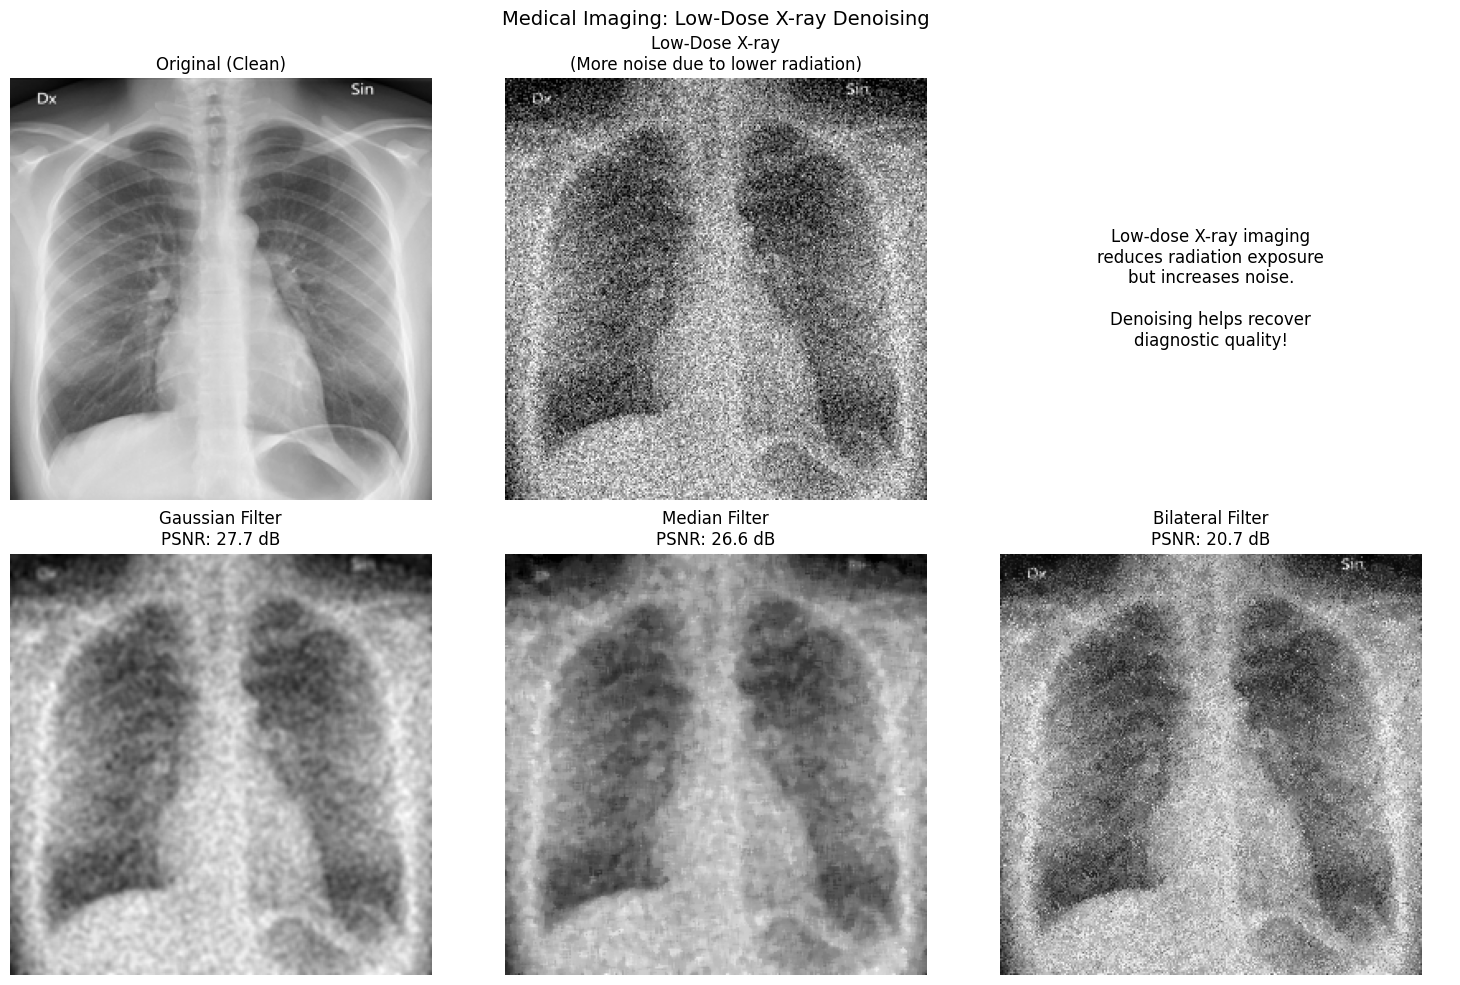

In [11]:
# Simulate low-dose X-ray (more noise)
np.random.seed(123)
low_dose_xray = add_gaussian_noise(original, sigma=40)
low_dose_xray = add_poisson_noise(low_dose_xray, scale=0.8)

# Apply different denoising methods
denoised_gaussian = convolve2d(low_dose_xray, gaussian_5x5)
denoised_median = median_filter(low_dose_xray, size=5)
denoised_bilateral = bilateral_filter(low_dose_xray, d=7, sigma_color=40, sigma_space=40)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(original, cmap='gray')
axes[0, 0].set_title('Original (Clean)')
axes[0, 0].axis('off')

axes[0, 1].imshow(low_dose_xray, cmap='gray')
axes[0, 1].set_title('Low-Dose X-ray\n(More noise due to lower radiation)')
axes[0, 1].axis('off')

axes[0, 2].axis('off')
axes[0, 2].text(0.5, 0.5, 'Low-dose X-ray imaging\nreduces radiation exposure\nbut increases noise.\n\nDenoising helps recover\ndiagnostic quality!',
                ha='center', va='center', fontsize=12, transform=axes[0, 2].transAxes)

axes[1, 0].imshow(denoised_gaussian, cmap='gray')
axes[1, 0].set_title(f'Gaussian Filter\nPSNR: {psnr(original, denoised_gaussian):.1f} dB')
axes[1, 0].axis('off')

axes[1, 1].imshow(denoised_median, cmap='gray')
axes[1, 1].set_title(f'Median Filter\nPSNR: {psnr(original, denoised_median):.1f} dB')
axes[1, 1].axis('off')

axes[1, 2].imshow(denoised_bilateral, cmap='gray')
axes[1, 2].set_title(f'Bilateral Filter\nPSNR: {psnr(original, denoised_bilateral):.1f} dB')
axes[1, 2].axis('off')

plt.suptitle('Medical Imaging: Low-Dose X-ray Denoising', fontsize=14)
plt.tight_layout()
plt.show()

## 11. Noise vs. Signal-to-Noise Ratio (SNR)

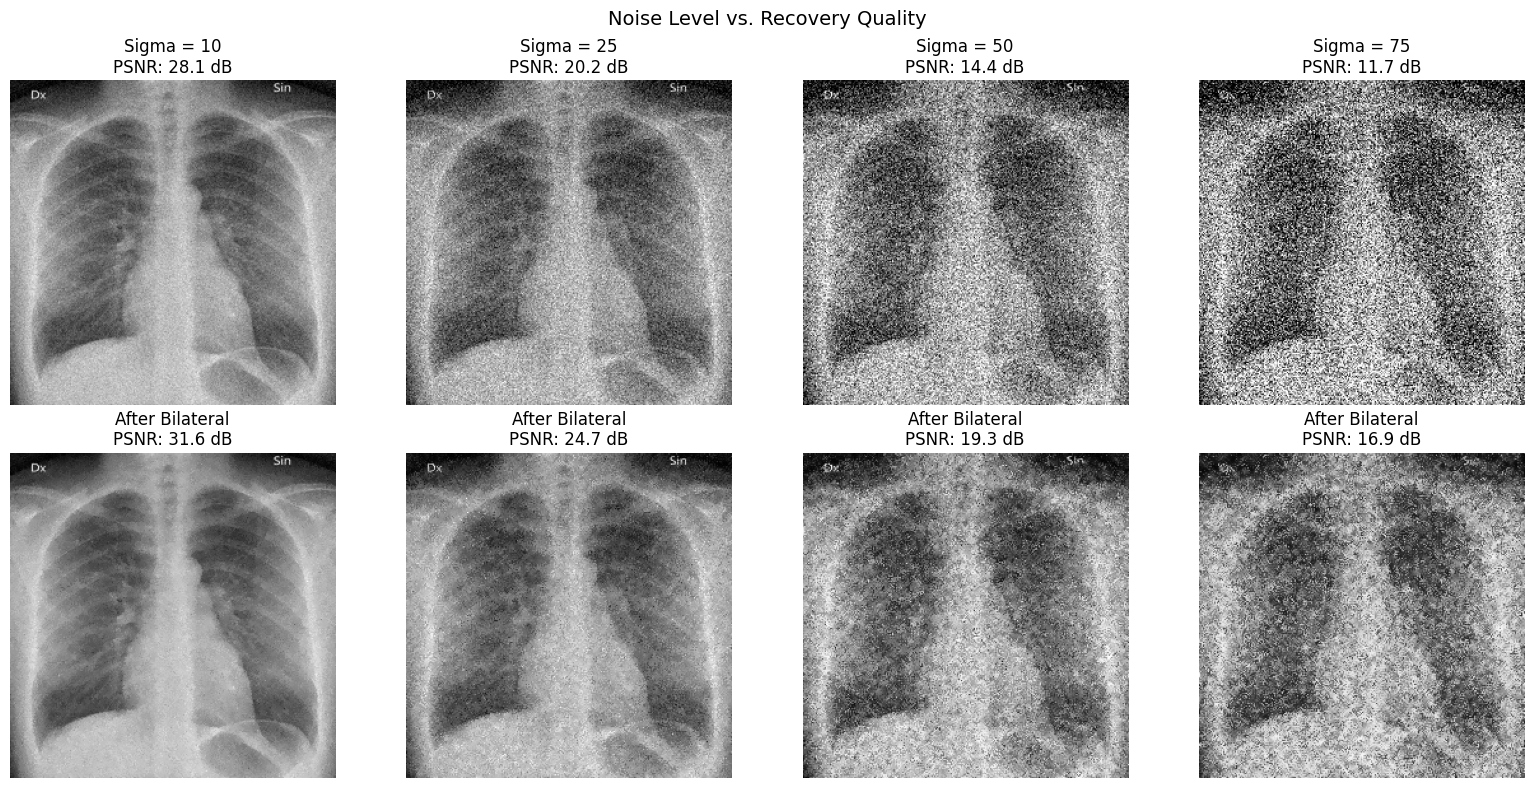

Observation: Higher noise = harder to recover original quality
But filtering still improves PSNR at all noise levels!


In [12]:
# Demonstrate different noise levels
noise_levels = [10, 25, 50, 75]
noisy_images = [add_gaussian_noise(original, sigma=s) for s in noise_levels]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, (sigma, noisy) in enumerate(zip(noise_levels, noisy_images)):
    # Noisy image
    axes[0, i].imshow(noisy, cmap='gray')
    p = psnr(original, noisy)
    axes[0, i].set_title(f'Sigma = {sigma}\nPSNR: {p:.1f} dB')
    axes[0, i].axis('off')
    
    # After filtering
    filtered = bilateral_filter(noisy, d=5, sigma_color=sigma, sigma_space=30)
    p_filtered = psnr(original, filtered)
    axes[1, i].imshow(filtered, cmap='gray')
    axes[1, i].set_title(f'After Bilateral\nPSNR: {p_filtered:.1f} dB')
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('Noisy', fontsize=12)
axes[1, 0].set_ylabel('Filtered', fontsize=12)

plt.suptitle('Noise Level vs. Recovery Quality', fontsize=14)
plt.tight_layout()
plt.show()

print("Observation: Higher noise = harder to recover original quality")
print("But filtering still improves PSNR at all noise levels!")

## 12. Summary

In [13]:
print("""
SUMMARY: IMAGE NOISE AND FILTERING
===================================

1. NOISE TYPES:
   - Gaussian: Random variation, normal distribution
   - Salt & Pepper: Random black/white pixels
   - Poisson: Signal-dependent (common in X-ray/CT)

2. LINEAR FILTERS:
   - Box (Mean) Filter: Simple average
   - Gaussian Filter: Weighted average, smoother
   - Good for: Gaussian noise
   - Problem: Blurs edges

3. NON-LINEAR FILTERS:
   - Median Filter: Replaces with median value
   - Best for: Salt & Pepper noise
   - Advantage: Preserves edges better

4. EDGE-PRESERVING:
   - Bilateral Filter: Combines spatial and intensity similarity
   - Smooths noise while keeping edges sharp

5. FILTER SIZE TRADE-OFF:
   - Larger kernel = More smoothing + More blur
   - Choose based on noise level

6. QUALITY METRICS:
   - PSNR (Peak Signal-to-Noise Ratio)
   - Higher PSNR = Better quality

7. MEDICAL IMAGING APPLICATION:
   - Low-dose imaging = More noise
   - Denoising enables lower radiation doses
   - Careful filter selection preserves diagnostic info

Choose the right filter for your noise type!
""")


SUMMARY: IMAGE NOISE AND FILTERING

1. NOISE TYPES:
   - Gaussian: Random variation, normal distribution
   - Salt & Pepper: Random black/white pixels
   - Poisson: Signal-dependent (common in X-ray/CT)

2. LINEAR FILTERS:
   - Box (Mean) Filter: Simple average
   - Gaussian Filter: Weighted average, smoother
   - Good for: Gaussian noise
   - Problem: Blurs edges

3. NON-LINEAR FILTERS:
   - Median Filter: Replaces with median value
   - Best for: Salt & Pepper noise
   - Advantage: Preserves edges better

4. EDGE-PRESERVING:
   - Bilateral Filter: Combines spatial and intensity similarity
   - Smooths noise while keeping edges sharp

5. FILTER SIZE TRADE-OFF:
   - Larger kernel = More smoothing + More blur
   - Choose based on noise level

6. QUALITY METRICS:
   - PSNR (Peak Signal-to-Noise Ratio)
   - Higher PSNR = Better quality

7. MEDICAL IMAGING APPLICATION:
   - Low-dose imaging = More noise
   - Denoising enables lower radiation doses
   - Careful filter selection preserves d